# Clean Bibliography

To goal of this notebook is to clean your `.bib` file to ensure that it only contains the full first names of references that you have cited in your paper. The full first names will then be used to query the probabilistic gender classifier, [Gender API](https://gender-api.com). The full names will be used to query for probabilistic race using the [ethnicolr package](https://ethnicolr.readthedocs.io/).

The only required file you need is your manuscript's bibliography in `.bib` format. __Your `.bib` must only contain references cited in the manuscript__. Otherwise, the estimated proportions will be inaccurate.

If you intend to analyze the reference list of a published paper instead of your own manuscript in progress, search the paper on [Web of Knowledge](http://apps.webofknowledge.com/) (you will need institutional access). Next, [download the .bib file from Web of Science following these instructions, but start from Step 4 and on Step 6 select BibTeX instead of Plain Text](https://github.com/jdwor/gendercitation/blob/master/Step0_PullingWOSdata.pdf).

If you are not using LaTeX, collect and organize only the references you have cited in your manuscript using your reference manager of choice (e.g. Mendeley, Zotero, EndNote, ReadCube, etc.) and export that selected bibliography as a `.bib` file. __Please try to export your .bib in an output style that uses full first names (rather than only first initials) and using the full author lists (rather than abbreviated author lists with "et al.").__ If first initials are included, our code will automatically retrieve about 70% of those names using the article title or DOI. 

   * [Export `.bib` from Mendeley](https://blog.mendeley.com/2011/10/25/howto-use-mendeley-to-create-citations-using-latex-and-bibtex/)
   * [Export `.bib` from Zotero](https://libguides.mit.edu/ld.php?content_id=34248570)
   * [Export `.bib` from EndNote](https://www.reed.edu/cis/help/LaTeX/EndNote.html). Note: Please export full first names by either [choosing an output style that does so by default (e.g. in MLA style)](https://canterbury.libguides.com/endnote/basics-output) or by [customizing an output style.](http://bibliotek.usn.no/cite-and-write/endnote/how-to-use/how-to-show-the-author-s-full-name-in-the-reference-list-article185897-28181.html)
   * [Export `.bib` from Read Cube Papers](https://support.papersapp.com/support/solutions/articles/30000024634-how-can-i-export-references-from-readcube-papers-)

For those working in LaTeX, we can use an optional `.aux` file to automatically filter your `.bib` to check that it only contains entries which are cited in your manuscript.

| Input                 | Output                                                                                                                        |
|-----------------------|-------------------------------------------------------------------------------------------------------------------------------|
| `.bib` file(s)**(REQUIRED)**    | `cleanBib.csv`: table of author first names, titles, and .bib keys                                                            |
| `.aux` file (OPTIONAL)| `predictions.csv`: table of author first names, estimated gender classification, and confidence                                   |
| `.tex` file (OPTIONAL) | `race_gender_citations.pdf`: heat map of your citations broken down by probabilistic gender and race estimations
|                       | `yourTexFile_gendercolor.tex`: your `.tex` file modified to compile .pdf with in-line citations colored-coded by gender pairs |

## 1. Import functions

Upload your `.bib` file(s) and _optionally_ an `.aux` file generated from compiling your LaTeX manuscript and your `.tex` file

![upload button](img/upload.png)

![confirm upload button](img/confirmUpload.png)

Then, run the code block below. (click to select the block and then press Ctrl+Enter; or click the block and press the Run button in the top menubar)

In [1]:
import numpy as np
import bibtexparser
from bibtexparser.bparser import BibTexParser
import glob
import subprocess
import os
from pybtex.database.input import bibtex
import csv
from pylatexenc.latex2text import LatexNodes2Text 
import unicodedata
import re
import pandas as pd
from habanero import Crossref
import string
from time import sleep
import tqdm
import matplotlib.pylab as plt
import matplotlib.gridspec as gridspec
import json
import pickle
from urllib.request import urlopen
from urllib.parse import quote
from ethnicolr import census_ln, pred_census_ln,pred_wiki_name
from pybtex.database import parse_file
import seaborn as sns


def checkcites_output(aux_file):
    '''take in aux file for tex document, return list of citation keys
    that are in .bib file but not in document'''

    result = subprocess.run(['texlua', 'checkcites.lua', aux_file[0]], stdout=subprocess.PIPE)
    result = result.stdout.decode('utf-8')
    unused_array_raw = result.split('\n')
    # process array of unused references + other output 
    unused_array_final = list()
    for x in unused_array_raw:
        if len(x) > 0: # if line is not empty
            if x[0] == '-':  # and if first character is a '-', it's a citation key
                unused_array_final.append(x[2:]) # truncate '- '            
    if "------------------------------------------------------------------------" in unused_array_final:
        return(result)
    else:
        return(unused_array_final)


def removeMiddleName(line):
    arr = line.split()
    last = arr.pop()
    n = len(arr)
    if n == 4:
        first, middle = ' '.join(arr[:2]), ' '.join(arr[2:])
    elif n == 3:
        first, middle = arr[0], ' '.join(arr[1:])
    elif n == 2:
        first, middle = arr
    elif n==1:
        return line
    return(str(first + ' ' + middle))


def returnFirstName(line):
    arr = line.split()
    n = len(arr)
    if n == 4:
        first, middle = ' '.join(arr[:2]), ' '.join(arr[2:])
    elif n == 3:
        first, middle = arr[0], ' '.join(arr[1:])
    elif n == 2:
        first, middle = arr
    elif n==1:
        return line
    return(str(middle))


def convertLatexSpecialChars(latex_text):
    return LatexNodes2Text().latex_to_text(latex_text)


def convertSpecialCharsToUTF8(text):
    data = LatexNodes2Text().latex_to_text(text)
    return unicodedata.normalize('NFD', data).encode('ascii', 'ignore').decode('utf-8')


def namesFromXref(doi, title, authorPos):
    '''Use DOI and article titles to query Crossref for author list'''
    if authorPos == 'first':
        idx = 0
    elif authorPos == 'last':
        idx = -1
    # get cross ref data
    authors = ['']
    # first try DOI
    if doi != "":
        works = cr.works(query = title, select = ["DOI","author"], limit=1, filter = {'doi': doi})
        if works['message']['total-results'] > 0:
            authors = works['message']['items'][0]['author']
    elif title != '': 
        works = cr.works(query = f'title:"{title}"', select = ["title","author"], limit=10)
        cnt = 0
        name = ''
        # check that you grabbed the proper paper
        if works['message']['items'][cnt]['title'][0].lower() == title.lower():
            authors = works['message']['items'][0]['author']

    # check the all fields are available
    if not 'given' in authors[idx]:
        name = ''
    else:
        # trim initials
        name = authors[idx]['given'].replace('.',' ').split()[0]

    return name


def namesFromXrefSelfCite(doi, title):
    selfCiteCheck = 0
    # get cross ref data
    authors = ['']
    # first try DOI
    if doi != "":
        works = cr.works(query = title, select = ["DOI","author"], limit=1, filter = {'doi': doi})
        if works['message']['total-results'] > 0:
            authors = works['message']['items'][0]['author']
    
    for i in authors:
        if i != "":
            first = i['given'].replace('.',' ').split()[0]
            last = i['family'].replace('.',' ').split()[0]
            authors = removeMiddleName(last + ", " + first)
            if authors in removeMiddleName(yourFirstAuthor) or authors in removeMiddleName(convertSpecialCharsToUTF8(yourFirstAuthor)) or authors in removeMiddleName(yourLastAuthor) or authors in removeMiddleName(convertSpecialCharsToUTF8(yourLastAuthor)):
                selfCiteCheck += 1
    return selfCiteCheck


cr = Crossref()
homedir = '/home/jovyan/'
bib_files = glob.glob(homedir + '*.bib')
paper_aux_file = glob.glob(homedir + '*.aux')
paper_bib_file = 'references.bib'
try:
    tex_file = glob.glob(homedir + "tex/*.tex")[0]
except:
    print('No optional .tex file found.')

Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/srv/conda/envs/notebook/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/traitlets/config/application.py", line 845, in launch_instance
    app.initialize(argv)
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/traitlets/config/application.py", line 88, in inner
    return method(app, *args, **kwargs)
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 632, in initialize
    self.init_sockets()
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 287, in init_sockets
    self.stdin_port = self._bind_socket(self.stdin_socke

### 2. Define the _first_ and _last_ author of your paper.

For example: 
```
yourFirstAuthor = 'Teich, Erin G.'
yourLastAuthor = 'Bassett, Danielle S.'
```

And optionally, define any co-first or co-last author(s), making sure to keep the square brackets to define a list.

For example:
```
optionalEqualContributors = ['Dworkin, Jordan', 'Stiso, Jennifer']
```

or 

```
optionalEqualContributors = ['Dworkin, Jordan']
```

If you are analyzing published papers' reference lists from Web of Science, change the variable checkingPublishedArticle to True:
```
checkingPublishedArticle = True
```

Then, run the code block below. (click to select the block and then press Ctrl+Enter; or click the block and press the Run button in the top menubar)

In [2]:
yourFirstAuthor = 'Vogelstein, Joshua T'
# yourFirstAuthor = 'Tester1-LastName, Tester1-FirstName'
yourLastAuthor = 'Yang, Weiwei'
# yourLastAuthor = 'Tester2-LastName, Tester2-FirstName'
optionalEqualContributors = ['LastName, FirstName OptionalMiddleInitial', 'LastName, FirstName OptionalMiddleInitial']
checkingPublishedArticle = False

if (yourFirstAuthor == 'LastName, FirstName OptionalMiddleInitial') or (yourLastAuthor == 'LastName, FirstName OptionalMiddleInitial'):
    raise ValueError("Please enter your manuscript's first and last author names")

if paper_aux_file:
    if optionalEqualContributors == ['LastName, FirstName OptionalMiddleInitial', 'LastName, FirstName OptionalMiddleInitial']:
        citing_authors = np.array([yourFirstAuthor, yourLastAuthor])
    else:
        citing_authors = np.array([yourFirstAuthor, yourLastAuthor, optionalEqualContributors])
    print(checkcites_output(paper_aux_file))
    unused_in_paper = checkcites_output(paper_aux_file) # get citations in library not used in paper
    print("Unused citations: ", unused_in_paper.count('=>'))
    
    
    parser = BibTexParser()
    parser.ignore_nonstandard_types = False
    parser.common_strings = True
    
    bib_data = None
    for bib_file in bib_files:
        with open(bib_file) as bibtex_file:
            if bib_data is None:
                bib_data = bibtexparser.bparser.BibTexParser(common_strings=True, ignore_nonstandard_types=False).parse_file(bibtex_file)
            else:
                bib_data_extra = bibtexparser.bparser.BibTexParser(common_strings=True, ignore_nonstandard_types=False).parse_file(bibtex_file)
                bib_data.entries_dict.update(bib_data_extra.entries_dict)
                bib_data.entries.extend(bib_data_extra.entries)
    
    all_library_citations = list(bib_data.entries_dict.keys())
    print("All citations: ", len(all_library_citations))
    
    for k in all_library_citations:
        if re.search('\\b'+ k + '\\b', unused_in_paper.replace('\n',' ').replace('=>',' ')) != None:
            del bib_data.entries_dict[k] # remove from entries dictionary if not in paper
            
    in_paper_mask = [re.search('\\b'+ bib_data.entries[x]['ID'] + '\\b', unused_in_paper.replace('\n',' ').replace('=>',' ')) == None for x in range(len(bib_data.entries))]
    bib_data.entries = [bib_data.entries[x] for x in np.where(in_paper_mask)[0]] # replace entries list with entries only in paper
    del bib_data.comments
    
    duplicates = []
    for key in bib_data.entries_dict.keys():
        count = str(bib_data.entries).count("'ID\': \'"+ key + "\'")
        if count > 1:
            duplicates.append(key)
            
    if len(duplicates) > 0:
        raise ValueError("In your .bib file, please remove duplicate entries or duplicate entry ID keys for:", ' '.join(map(str, duplicates)))

    if os.path.exists(paper_bib_file):
        os.remove(paper_bib_file)
    
    with open(paper_bib_file, 'w') as bibtex_file:
        bibtexparser.dump(bib_data, bibtex_file)
    
    # define first author and last author names of citing paper -- will exclude citations of these authors
    # beware of latex symbols within author names
    # in_paper_citations = list(bib_data.entries_dict.keys())
    in_paper_citations = [bib_data.entries[x]['ID'] for x in range(len(bib_data.entries))] # get list of citation keys in paper
    
    # extract author list for every cited paper
    cited_authors = [bib_data.entries_dict[x]['author'] for x in in_paper_citations]
    # find citing authors in cited author list
    # using nested list comprehension, make a citing author -by- citation array of inclusion
    self_cite_mask = np.array([[str(citing_author) in authors for authors in cited_authors] for citing_author in citing_authors])
    self_cite_mask = np.any(self_cite_mask,axis=0) # collapse across citing authors such that any coauthorship by either citing author -> exclusion
    
    print("Self-citations: ", [bib_data.entries[x]['ID'] for x in np.where(self_cite_mask)[0]]) # print self citations
    for idx,k in enumerate(in_paper_citations):
        if self_cite_mask[idx]:
            del bib_data.entries_dict[k] # delete citation from dictionary if self citationi
    bib_data.entries = [bib_data.entries[x] for x in np.where(np.invert(self_cite_mask))[0]] # replace entries list with entries that aren't self citations
    
    paper_bib_file_excl_sc = os.path.splitext(paper_bib_file)[0] + '_noselfcite.bib'
    
    if os.path.exists(paper_bib_file_excl_sc):
        os.remove(paper_bib_file_excl_sc)
    
    with open(paper_bib_file_excl_sc, 'w') as bibtex_file:
        bibtexparser.dump(bib_data, bibtex_file)
        
    ID = glob.glob(homedir + paper_bib_file_excl_sc)
else:
    ID = glob.glob(homedir + '*bib')
    with open(ID[0]) as bibtex_file:
        bib_data = bibtexparser.bparser.BibTexParser(common_strings=True, ignore_nonstandard_types=False).parse_file(bibtex_file)
    duplicates = []
    for key in bib_data.entries_dict.keys():
        count = str(bib_data.entries).count("'ID\': \'"+ key + "\'")
        if count > 1:
            duplicates.append(key)
            
    if len(duplicates) > 0:
        raise ValueError("In your .bib file, please remove duplicate entries or duplicate entry ID keys for:", ' '.join(map(str, duplicates)))

if checkingPublishedArticle == True:
    FA = []
    LA = []
    counter = 1
    selfCiteCount = 0
    titleCount = 1 # 
    counterNoDOI = list() # row index (titleCount) of entries with no DOI
    outPath = homedir + 'cleanedBib.csv'

    if os.path.exists(outPath):
        os.remove(outPath)

    with open(outPath, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
        writer.writerow(['Article', 'FA', 'LA', 'Title', 'SelfCite', 'CitationKey'])
    
    citedArticleDOI = list()
    citedArticleNoDOI = list()
    allArticles = list()
    for entry in bib_data.entries:
        my_string= entry['cited-references'].split('\n')
        for citedArticle in my_string:
            allArticles.append(citedArticle)
            if citedArticle.partition("DOI ")[-1]=='':
                citedArticleNoDOI.append(citedArticle)
                counterNoDOI.append(titleCount)
            else:
                line = citedArticle.partition("DOI ")[-1].replace("DOI ","").rstrip(".")
                line = ''.join( c for c in line if  c not in '{[}] ')
                if "," in line:
                    line = line.partition(",")[-1]
                citedArticleDOI.append(line)
                with open('citedArticlesDOI.csv', 'a', newline='') as csvfile:
                    writer = csv.writer(csvfile, delimiter=',')
                    writer.writerow([line])
            titleCount += 1

    articleNum = 0
    for doi in citedArticleDOI:
        try:
            FA = namesFromXref(doi, '', 'first')
        except UnboundLocalError:
            sleep(1)
            continue

        try:
            LA = namesFromXref(doi, '', 'last')
        except UnboundLocalError:
            sleep(1)
            continue

        try:
            selfCiteCount = namesFromXrefSelfCite(doi, '')
        except UnboundLocalError:
            sleep(1)
            continue

        with open(outPath, 'a', newline='') as csvfile:            
            if selfCiteCount == 0:
                writer = csv.writer(csvfile, delimiter=',')
                getArticleIndex = [i for i, s in enumerate(allArticles) if doi in s]
                writer.writerow([counter, convertSpecialCharsToUTF8(FA), convertSpecialCharsToUTF8(LA), allArticles[[i for i, s in enumerate(allArticles) if doi in s][0]], '', ''])
                print(str(counter) + ": " + doi )
                counter += 1
            else:
                print(str(articleNum) + ": " + doi + "\t\t\t <-- self-citation" )
        articleNum += 1

    if len(citedArticleNoDOI)>0:
        print()
        for elem in citedArticleNoDOI:
            with open(outPath, 'a', newline='') as csvfile:            
                writer = csv.writer(csvfile, delimiter=',')
                writer.writerow([counter, '', '', elem, '', ''])
                print(str(counter) + ": " + elem )
            counter += 1
        print()
        raise ValueError("WARNING: No article DOI was provided for the last " + str(len(citedArticleNoDOI)) + " listed papers. Please manually search for these articles. IF AND ONLY IF your citing paper's first and last author are not co-authors in the paper that was cited, enter the first name of the first and last authors of the paper that was cited manually. Then, continue to the next code block.")
else:
    FA = []
    LA = []
    parser = bibtex.Parser()
    bib_data = parser.parse_file(ID[0])
    counter = 1
    nameCount = 0
    outPath = homedir + 'cleanedBib.csv'

    if os.path.exists(outPath):
        os.remove(outPath)

    with open(outPath, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
        writer.writerow(['Article', 'FA', 'LA', 'Title', 'SelfCite', 'CitationKey'])

    for key in bib_data.entries.keys():
        diversity_bib_titles = ['The extent and drivers of gender imbalance in neuroscience reference lists',
                                'The gender citation gap in international relations',
                                'Quantitative evaluation of gender bias in astronomical publications from citation counts',
                                '\# CommunicationSoWhite',
                                '{Just Ideas? The Status and Future of Publication Ethics in Philosophy: A White Paper}',
                                'Gendered citation patterns across political science and social science methodology fields',
                                'Gender Diversity Statement and Code Notebook v1.0', 
                                'Racial and ethnic imbalance in neuroscience reference lists and intersections with gender', 
                                'Gender Diversity Statement and Code Notebook v1.1',
                                'Gendered citation practices in the field of communication',
                                'Gender disparity in citations in high- impact journal articles',
                                'Gender (im)balance in citation practices in cognitive neuroscience',
                                'Name-ethnicity classification from open sources',
                                'Predicting race and ethnicity from the sequence of characters in a name']
        if bib_data.entries[key].fields['title'] in diversity_bib_titles:
            continue

        try:
            author = bib_data.entries[key].persons['author']
        except:
            author = bib_data.entries[key].persons['editor']
        FA = author[0].rich_first_names
        LA = author[-1].rich_first_names
        FA = convertLatexSpecialChars(str(FA)[7:-3]).translate(str.maketrans('', '', string.punctuation)).replace('Protected',"").replace(" ",'')
        LA = convertLatexSpecialChars(str(LA)[7:-3]).translate(str.maketrans('', '', string.punctuation)).replace('Protected',"").replace(" ",'')
        
        # check if we grabbed a first initial when a full middle name was available
        if (len(FA) == 1):
            mn = author[0].rich_middle_names
            mn = convertLatexSpecialChars(str(mn)[7:-3]).translate(str.maketrans('', '', string.punctuation)).replace('Protected',"").replace(" ",'')
            if len(mn) > 1:
                FA = mn
        if (len(LA) == 1):
            mn = author[-1].rich_middle_names
            mn = convertLatexSpecialChars(str(mn)[7:-3]).translate(str.maketrans('', '', string.punctuation)).replace('Protected',"").replace(" ",'')
            if len(mn) > 1:
                LA = mn
        
        # check that we got a name (not an initial) from the bib file, if not try using the title in the crossref API
        try:
            title = bib_data.entries[key].fields['title'].replace(',', '').replace(',', '').replace('{','').replace('}','')
        except:
            title = ''
        try:
            doi =  bib_data.entries[key].fields['doi']
        except:
            doi = ''
        if FA == '' or len(FA.split('.')[0]) <= 1:
            while True:
                try:
                    FA = namesFromXref(doi, title, 'first')
                except UnboundLocalError:
                    sleep(1)
                    continue
                break
        if LA == '' or len(LA.split('.')[0]) <= 1:
            while True:
                try:
                    LA = namesFromXref(doi, title, 'last')
                except UnboundLocalError:
                    sleep(1)
                    continue
                break

        if (yourFirstAuthor!='LastName, FirstName OptionalMiddleInitial') and (yourLastAuthor!='LastName, FirstName OptionalMiddleInitial'):
            selfCiteCheck1 = [s for s in author if removeMiddleName(yourLastAuthor) in str([convertLatexSpecialChars(str(s.rich_last_names)[7:-3]).replace("', Protected('","").replace("'), '", ""), convertLatexSpecialChars(str(s.rich_first_names)[7:-3]).replace("', Protected('","").replace("'), '", "")]).replace("'", "")]
            selfCiteCheck1a = [s for s in author if removeMiddleName(yourLastAuthor) in str([convertSpecialCharsToUTF8(str(s.rich_last_names)[7:-3]).replace("', Protected('","").replace("'), '", ""), convertSpecialCharsToUTF8(str(s.rich_first_names)[7:-3]).replace("', Protected('","").replace("'), '", "")]).replace("'", "")]
            selfCiteCheck1b = [s for s in author if removeMiddleName(yourLastAuthor) in str([convertSpecialCharsToUTF8(str(s.rich_last_names)[7:-3]).replace("', Protected('","").replace("'), '", ""), LA]).replace("'", "")]

            selfCiteCheck2 = [s for s in author if removeMiddleName(yourFirstAuthor) in str([convertLatexSpecialChars(str(s.rich_last_names)[7:-3]).replace("', Protected('","").replace("'), '", ""), convertLatexSpecialChars(str(s.rich_first_names)[7:-3]).replace("', Protected('","").replace("'), '", "")]).replace("'", "")]
            selfCiteCheck2a = [s for s in author if removeMiddleName(yourFirstAuthor) in str([convertSpecialCharsToUTF8(str(s.rich_last_names)[7:-3]).replace("', Protected('","").replace("'), '", ""), convertSpecialCharsToUTF8(str(s.rich_first_names)[7:-3]).replace("', Protected('","").replace("'), '", "")]).replace("'", "")]
            selfCiteCheck2b = [s for s in author if removeMiddleName(yourFirstAuthor) in str([convertSpecialCharsToUTF8(str(s.rich_last_names)[7:-3]).replace("', Protected('","").replace("'), '", ""), FA]).replace("'", "")]

            nameCount = 0
            if optionalEqualContributors != ('LastName, FirstName OptionalMiddleInitial', 'LastName, FirstName OptionalMiddleInitial'):
                for name in optionalEqualContributors:
                    selfCiteCheck3 = [s for s in author if removeMiddleName(name) in str([convertLatexSpecialChars(str(s.rich_last_names)[7:-3]).replace("', Protected('","").replace("'), '", ""), convertLatexSpecialChars(str(s.rich_first_names)[7:-3]).replace("', Protected('","").replace("'), '", "")]).replace("'", "")]
                    selfCiteCheck3a = [s for s in author if removeMiddleName(name) in str([convertSpecialCharsToUTF8(str(s.rich_last_names)[7:-3]).replace("', Protected('","").replace("'), '", ""), convertSpecialCharsToUTF8(str(s.rich_first_names)[7:-3]).replace("', Protected('","").replace("'), '", "")]).replace("'", "")]
                    if len(selfCiteCheck3)>0:
                        nameCount += 1
                    if len(selfCiteCheck3a)>0:
                        nameCount += 1
            selfCiteChecks = [selfCiteCheck1, selfCiteCheck1a, selfCiteCheck1b, selfCiteCheck2, selfCiteCheck2a, selfCiteCheck2b]
            if sum([len(check) for check in selfCiteChecks]) + nameCount > 0:
                selfCite = 'Y'
                if len(FA) < 2:
                    print(str(counter) + ": " + key + "\t\t  <-- self-citation <--  ***NAME MISSING OR POSSIBLY INCOMPLETE***")
                else:
                    print(str(counter) + ": " + key + "  <-- self-citation")
            else:
                selfCite= 'N'
                if len(FA) < 2:
                    print(str(counter) + ": " + key + "\t\t  <--  ***NAME MISSING OR POSSIBLY INCOMPLETE***")
                else:
                    print(str(counter) + ": " + key)
        else:
            selfCite = 'NA'

        with open(outPath, 'a', newline='') as csvfile:
            writer = csv.writer(csvfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
            writer.writerow([counter, convertSpecialCharsToUTF8(FA), convertSpecialCharsToUTF8(LA), title, selfCite, key])
        counter += 1

     _           _       _ _
 ___| |_ ___ ___| |_ ___|_| |_ ___ ___
|  _|   | -_|  _| '_|  _| |  _| -_|_ -|
|___|_|_|___|___|_,_|___|_|_| |___|___|

checkcites.lua -- a reference checker script (v2.4)
Copyright (c) 2012, 2019, Enrico Gregorio, Paulo Roberto Massa Cereda

Great, I found 226 citations in 1 file. I also found 1 bibliography file.
Let me check this file and extract the references. Please wait a moment.

Fantastic, I found 225 references in 1 bibliography file. Please wait a
moment while the reports are generated.

--------------------------------------------------------------------------
Report of unused references in your TeX document (that is, references
present in bibliography files, but not cited in the TeX source file)
--------------------------------------------------------------------------

Unused references in your TeX document: 0

--------------------------------------------------------------------------
Report of undefined references in your TeX document (that i

BibTeX item 'comments' does not exist and will not be written. Valid items are ['entries', 'comments', 'preambles', 'strings'].
BibTeX item 'comments' does not exist and will not be written. Valid items are ['entries', 'comments', 'preambles', 'strings'].


Self-citations:  ['Athreya2017-us', 'Geisa2021-uc', 'Priebe2020-jn', 'Rose2020-zm', 'Vogelstein2007-wz', 'Vogelstein2020-et']
1: Allen2006-sv
2: Antos1999-wh
3: Arjovsky2021-mm
4: Atsumi2018-ma
5: Bacon2017-yf
6: Baez1979-jr
7: bahdanau2014neural
8: Balcan2009-wm
9: Balcan2010-bu
10: Barocas2016-ip
11: Barto1983-uy
12: barto2003recent
13: Baxter2000-wv
14: Bayern2018-rv
15: Bellman1956-vc
16: Bengio1992-pe
17: Bengio2013-ln
18: Bengio2017-nr
19: benton2020learning
20: Berlyne1955-cc
21: bietti2021sample
22: Birhane2021-zi
23: Boulton2017-qx
24: Bouton1993-mi
25: Bouton2019-mg
26: Bozinovski1976-ij
27: Breiman2001-ag
28: Brown2020-tz
29: Calhoun2014-vu
30: Call2004-ag
31: Cantelli1933-vj
32: Caruana1997-mm
33: Cesa-Bianchi2006-tv
34: chatzipantazis2021learning
35: Cheney1990-ab
36: Cheney1995-kc
37: Chirimuuta2018-np
38: Chu2020-ho
39: Clayton2003-ds
40: Clayton2005-ln
41: cldm-workshop
42: cohen2016group
43: Collier-Baker2004-gf
44: Constantinescu2016-cc
45: crl-page
46: csdm-workshop


## 3. Estimate gender and race of authors from cleaned bibliography

### Checkpoint for cleaned bibliography and using Gender API to estimate genders and race by names
After registering for a [gender-api](https://gender-api.com/) (free account available), use your 500 free monthly search credits by __pasting your API key in the code for the line indicated below__ (replace only YOUR ACCOUNT KEY HERE):

```genderAPI_key <- '&key=YOUR ACCOUNT KEY HERE'```

[You can find your key in your account's profile page.](https://gender-api.com/en/account/overview#my-api-key)

__NOTE__: Please edit your .bib file using information printed by the code and provided in cleanedBib.csv. Edit directly within the Binder environment by clicking the .bib file (as shown below), making modifications, and saving the file (as shown below).

![open button](img/openBib.png)

![save button](img/saveBib.png)

Common issues include: 

* Bibliography entry did not include a last author because the author list was truncated by "and Others" or "et al." 
* Some older journals articles only provide first initial and not full first names, in which case you will need to go digging via Google to identify that person. 
* In rare cases where the author cannot be identified even after searching by hand, replace the first name with "UNKNOWNNAMES" so that the classifier will estimate the gender as unknown. 

__NOTE__: your free account has 500 queries per month. This box contains the code that will use your limited API credits/queries if it runs without error. Re-running all code repeatedly will repeatedly use these credits.

Then, run the code blocks below. (click to select the block and then press Ctrl+Enter; or click the block and press the Run button in the top menubar)

In [3]:
genderAPI_key <- '&key=PLACE-THE-KEY-HERE'

fileConn<-file("genderAPIkey.txt")
writeLines(c(genderAPI_key), fileConn)
close(fileConn)

names=read.csv("/home/jovyan/cleanedBib.csv",stringsAsFactors=F)
setwd('/home/jovyan/')

require(rjson)
gendFA=NULL;gendLA=NULL
gendFA_conf=NULL;gendLA_conf=NULL

namesIncompleteFA=NULL
namesIncompleteLA=NULL
incompleteKeys=list()
incompleteRows=list()

for(i in 1:nrow(names)){
  if (nchar(names$FA[i])<2 || grepl("\\.", names$FA[i])){
    namesIncompleteFA[i] = i+1
    incompleteKeys = c(incompleteKeys, names$CitationKey[i])
    incompleteRows = c(incompleteRows, i+1)
  }
  namesIncompleteFA = namesIncompleteFA[!is.na(namesIncompleteFA)]
    
  if (nchar(names$LA[i])<2 || grepl("\\.", names$LA[i])){
    namesIncompleteLA[i] = i+1
    incompleteKeys = c(incompleteKeys, names$CitationKey[i])
    incompleteRows = c(incompleteRows, i+1)
  }
  namesIncompleteLA = namesIncompleteLA[!is.na(namesIncompleteLA)]
}

if (length(names$CitationKey[which(names$SelfCite=="Y")]>0)){
    print(paste("STOP: Please remove self-citations. Then, re-run steps 2 and 3. Here are some suggestions to check for with the following citation keys in your .bib file: "))
    print(paste(names$CitationKey[which(names$SelfCite=="Y")]))
}

if (length(namesIncompleteFA)>0 || length(namesIncompleteLA)>0){
    print(paste("STOP: Please revise incomplete full first names or empty cells. Then, re-run steps 2 and 3. Here are some suggestions to check for with the following citation keys in your .bib file: "))
    print(paste(incompleteKeys))
    print(paste("Only continue if you've ran steps 2 and 3, and this code for step 3 no longer returns errors. For accuracy, please revise any incomplete names in the citations of your .bib file as indicated above. For more info, see rows", paste(unique(c(namesIncompleteFA, namesIncompleteLA))), "of cleanedBib.csv"))
}

Loading required package: rjson



## 4. Describe the proportions of genders in your reference list and compare it to published base rates in neuroscience.

__NOTE__: your free GenderAPI account has 500 queries per month. This box contains the code that will use your limited API credits/queries if it runs without error. Re-running all code repeatedly will repeatedly use these credits.

Run the code blocks below. (click to select the block and then press Ctrl+Enter; or click the block and press the Run button in the top menubar)

In [4]:
from ethnicolr import pred_fl_reg_name
f = open("genderAPIkey.txt", "r")
genderAPI_key = f.readline().replace('\n', '')

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import argparse
parser = argparse.ArgumentParser()
parser.add_argument('-bibfile',action='store',dest='bibfile',default=' '.join(bib_files))
parser.add_argument('-homedir',action='store',dest='homedir',default='/home/jovyan/')
parser.add_argument('-authors',action='store',dest='authors', default=(yourFirstAuthor+' '+yourLastAuthor).replace(',',''))
parser.add_argument('-method',action='store',dest='method',default='florida')
parser.add_argument('-font',action='store',dest='font',default='Palatino') # hey, we all have our favorite
parser.add_argument('-gender_key',action='store',dest='gender_key',default=genderAPI_key)
r = parser.parse_args()
locals().update(r.__dict__)
bibfile = bib_data


def gender_base():
	"""
	for unknown gender, fill with base rates
	you will never / can't run this (that file is too big to share)
	"""
	main_df = pd.read_csv('/%s/data/NewArticleData2019.csv'%(homedir),header=0)


	gender_base = {}
	for year in np.unique(main_df.PY.values):
		ydf = main_df[main_df.PY==year].AG
		fa = np.array([x[0] for x in ydf.values])
		la = np.array([x[1] for x in ydf.values])

		fa_m = len(fa[fa=='M'])/ len(fa[fa!='U'])
		fa_w = len(fa[fa=='W'])/ len(fa[fa!='U'])

		la_m = len(la[fa=='M'])/ len(la[la!='U'])
		la_w = len(la[fa=='W'])/ len(la[la!='U'])

		gender_base[year] = [fa_m,fa_w,la_m,la_w]

	gender_base[2020] = [fa_m,fa_w,la_m,la_w]

	with open(homedir + '/data/gender_base' + '.pkl', 'wb') as f:
		pickle.dump(gender_base, f, pickle.HIGHEST_PROTOCOL)


with open(homedir + 'data/gender_base' + '.pkl', 'rb') as f:
	gender_base =  pickle.load(f)

authors = authors.split(' ')
print ('first author is %s %s '%(authors[1],authors[0]))
print ('last author is %s %s '%(authors[3],authors[2]))
print ("we don't count these, but check the predictions file to ensure your names did not slip through!")

citation_matrix = np.zeros((8,8))
matrix_idxs = {'white_m':0,'api_m':1,'hispanic_m':2,'black_m':3,'white_f':4,'api_f':5,'hispanic_f':6,'black_f':7}

asian = [0,1,2]
black = [3,4]
white = [5,6,7,8,9,11,12]
hispanic = [10]
print ('looping through your references, predicting gender and race')

columns=['CitationKey','Author','Gender','W','A', 'GendCat']
paper_df = pd.DataFrame(columns=columns)

gender = []
race = []


idx = 0
for paper in tqdm.tqdm(bibfile.entries,total=len(bibfile.entries)): 
	if 'author' not in bibfile.entries[paper].persons.keys():
		continue #some editorials have no authors
	if 'year' not in bibfile.entries[paper].fields.keys():
		year = 2020
	else: year = int(bibfile.entries[paper].fields['year'])  
	
	if year not in gender_base.keys():
		gb = gender_base[1995]
	else:
		gb = gender_base[year]

	fa = bibfile.entries[paper].persons['author'][0]
	try:fa_fname = fa.first_names[0] 
	except:fa_fname = fa.last_names[0] #for people like Plato
	fa_lname = fa.last_names[0] 

	la = bibfile.entries[paper].persons['author'][-1]
	try:la_fname = la.first_names[0] 
	except:la_fname = la.last_names[0] #for people like Plato
	la_lname = la.last_names[0]

	if fa_fname.lower().strip() == authors[1].lower().strip():
		if fa_lname.lower().strip()  == authors[0].lower().strip() :
			continue

	if fa_fname.lower().strip()  == authors[3].lower().strip() :
		if fa_lname.lower().strip()  == authors[2].lower().strip() :
			continue

	if la_fname.lower().strip()  == authors[1].lower().strip() :
		if la_lname.lower().strip()  == authors[0].lower().strip() :
			continue
	
	if la_fname.lower().strip()  == authors[3].lower().strip() :
		if la_lname.lower().strip()  == authors[2].lower().strip() :
			continue

	fa_fname = convertLatexSpecialChars(str(fa_fname.encode("ascii", errors="ignore").decode())).translate(str.maketrans('', '', re.sub('\-', '', string.punctuation))).replace('Protected',"").replace(" ",'')
	fa_lname = convertLatexSpecialChars(str(fa_lname.encode("ascii", errors="ignore").decode())).translate(str.maketrans('', '', re.sub('\-', '', string.punctuation))).replace('Protected',"").replace(" ",'')
	la_fname = convertLatexSpecialChars(str(la_fname.encode("ascii", errors="ignore").decode())).translate(str.maketrans('', '', re.sub('\-', '', string.punctuation))).replace('Protected',"").replace(" ",'') 
	la_lname = convertLatexSpecialChars(str(la_lname.encode("ascii", errors="ignore").decode())).translate(str.maketrans('', '', re.sub('\-', '', string.punctuation))).replace('Protected',"").replace(" ",'')

	names = [{'lname': fa_lname,'fname':fa_fname}]
	fa_df = pd.DataFrame(names,columns=['fname','lname'])
	asian,hispanic,black,white = pred_fl_reg_name(fa_df,'lname','fname').values[0][-4:]
	fa_race = [white,asian,hispanic,black]
	
	names = [{'lname': la_lname,'fname':la_fname}]
	la_df = pd.DataFrame(names,columns=['fname','lname'])
	asian,hispanic,black,white = pred_fl_reg_name(la_df,'lname','fname').values[0][-4:]
	la_race = [white,asian,hispanic,black]

	url = "https://gender-api.com/get?key=" + gender_key + "&name=%s" %(quote(fa_fname))
	response = urlopen(url)
	decoded = response.read().decode('utf-8')
	fa_gender = json.loads(decoded)
	if fa_gender['gender'] == 'female':
		fa_g = [0,fa_gender['accuracy']/100.]
	if fa_gender['gender'] == 'male':
		fa_g = [fa_gender['accuracy']/100.,0]
	if fa_gender['gender'] == 'unknown':
		fa_g = gb[:2]

	url = "https://gender-api.com/get?key=" + gender_key + "&name=%s" %(quote(la_fname))
	response = urlopen(url)
	decoded = response.read().decode('utf-8')
	la_gender = json.loads(decoded)
	if la_gender['gender'] == 'female':
		la_g = [0,la_gender['accuracy']/100.]
	
	if la_gender['gender'] == 'male':
		la_g = [la_gender['accuracy']/100.,0]

	if la_gender['gender'] == 'unknown':
		la_g = gb[2:] 
	
	fa_data = np.array([paper,'%s,%s'%(fa_fname,fa_lname),'%s,%s'%(fa_gender['gender'],fa_gender['accuracy']),fa_race[0],np.sum(fa_race[1:]), '']).reshape(1,6)
	paper_df = paper_df.append(pd.DataFrame(fa_data,columns=columns),ignore_index =True)
	la_data = np.array([paper,'%s,%s'%(la_fname,la_lname),'%s,%s'%(la_gender['gender'],la_gender['accuracy']),la_race[0],np.sum(la_race[1:]), '%s%s' % (fa_gender['gender'], la_gender['gender'])]).reshape(1,6)
	paper_df = paper_df.append(pd.DataFrame(la_data,columns=columns),ignore_index =True)

	mm = fa_g[0]*la_g[0]
	wm = fa_g[1]*la_g[0]
	mw = fa_g[0]*la_g[1]
	ww = fa_g[1]*la_g[1]
	mm,wm,mw,ww = [mm,wm,mw,ww]/np.sum([mm,wm,mw,ww])
	
	gender.append([mm,wm,mw,ww])

	ww = fa_race[0] * la_race[0]
	aw = np.sum(fa_race[1:]) * la_race[0]
	wa = fa_race[0] * np.sum(la_race[1:])
	aa = np.sum(fa_race[1:]) * np.sum(la_race[1:])

	race.append([ww,aw,wa,aa])

	paper_matrix = np.zeros((2,8))
	paper_matrix[0] = np.outer(fa_g,fa_race).flatten() 
	paper_matrix[1] = np.outer(la_g,la_race).flatten() 

	paper_matrix = np.outer(paper_matrix[0],paper_matrix[1]) 

	citation_matrix = citation_matrix + paper_matrix
	idx = idx + 1

mm,wm,mw,ww = np.mean(gender,axis=0)*100
WW,aw,wa,aa = np.mean(race,axis=0)*100

statement = "Recent work in several fields of science has identified a bias in citation practices such that papers from women and other minority scholars \
are under-cited relative to the number of such papers in the field (1-9). Here we sought to proactively consider choosing references that reflect the \
diversity of the field in thought, form of contribution, gender, race, ethnicity, and other factors. First, we obtained the predicted gender of the first \
and last author of each reference by using databases that store the probability of a first name being carried by a woman (5, 10). By this measure \
(and excluding self-citations to the first and last authors of our current paper), our references contain ww% woman(first)/woman(last), \
MW% man/woman, WM% woman/man, and MM% man/man. This method is limited in that a) names, pronouns, and social media profiles used to construct the \
databases may not, in every case, be indicative of gender identity and b) it cannot account for intersex, non-binary, or transgender people. \
Second, we obtained predicted racial/ethnic category of the first and last author of each reference by databases that store the probability of a \
first and last name being carried by an author of color (11, 12). By this measure (and excluding self-citations), our references contain AA% author of \
color (first)/author of color(last), WA% white author/author of color, AW% author of color/white author, and WW% white author/white author. This method \
is limited in that a) names and Florida Voter Data to make the predictions may not be indicative of racial/ethnic identity, and b) \
it cannot account for Indigenous and mixed-race authors, or those who may face differential biases due to the ambiguous racialization or ethnicization of their names.  \
We look forward to future work that could help us to better understand how to support equitable practices in science."

statement = statement.replace('MM',str(np.around(mm,2)))
statement = statement.replace('WM',str(np.around(wm,2)))
statement = statement.replace('MW',str(np.around(mw,2)))
statement = statement.replace('ww',str(np.around(ww,2)))
statement = statement.replace('WW',str(np.around(WW,2)))
statement = statement.replace('AW',str(np.around(aw,2)))
statement = statement.replace('WA',str(np.around(wa,2)))
statement = statement.replace('AA',str(np.around(aa,2)))

statementLatex = "Recent work in several fields of science has identified a bias in citation practices such that papers from women and other minority scholars \
are under-cited relative to the number of such papers in the field \cite{mitchell2013gendered,dion2018gendered,caplar2017quantitative, maliniak2013gender, Dworkin2020.01.03.894378, bertolero2021racial, wang2021gendered, chatterjee2021gender, fulvio2021imbalance}. Here we sought to proactively consider choosing references that reflect the\
diversity of the field in thought, form of contribution, gender, race, ethnicity, and other factors. First, we obtained the predicted gender of the first \
and last author of each reference by using databases that store the probability of a first name being carried by a woman \cite{Dworkin2020.01.03.894378,zhou_dale_2020_3672110}. By this measure \
(and excluding self-citations to the first and last authors of our current paper), our references contain ww\% woman(first)/woman(last), \
MW\% man/woman, WM\% woman/man, and MM\% man/man. This method is limited in that a) names, pronouns, and social media profiles used to construct the \
databases may not, in every case, be indicative of gender identity and b) it cannot account for intersex, non-binary, or transgender people. \
Second, we obtained predicted racial/ethnic category of the first and last author of each reference by databases that store the probability of a \
first and last name being carried by an author of color \cite{ambekar2009name, sood2018predicting}. By this measure (and excluding self-citations), our references contain AA\% author of \
color (first)/author of color(last), WA\% white author/author of color, AW\% author of color/white author, and WW\% white author/white author. This method \
is limited in that a) names and Florida Voter Data to make the predictions may not be indicative of racial/ethnic identity, and b) \
it cannot account for Indigenous and mixed-race authors, or those who may face differential biases due to the ambiguous racialization or ethnicization of their names.  \
We look forward to future work that could help us to better understand how to support equitable practices in science."

statementLatex = statementLatex.replace('MM',str(np.around(mm,2)))
statementLatex = statementLatex.replace('WM',str(np.around(wm,2)))
statementLatex = statementLatex.replace('MW',str(np.around(mw,2)))
statementLatex = statementLatex.replace('ww',str(np.around(ww,2)))
statementLatex = statementLatex.replace('WW',str(np.around(WW,2)))
statementLatex = statementLatex.replace('AW',str(np.around(aw,2)))
statementLatex = statementLatex.replace('WA',str(np.around(wa,2)))
statementLatex = statementLatex.replace('AA',str(np.around(aa,2)))

first author is Joshua Vogelstein 
last author is Yang T 
we don't count these, but check the predictions file to ensure your names did not slip through!
looping through your references, predicting gender and race


  0%|          | 0/219 [00:00<?, ?it/s]2022-01-14 02:56:28.097907: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-01-14 02:56:28.116909: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 3099995000 Hz
2022-01-14 02:56:28.117915: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x555892684b10 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-01-14 02:56:28.118069: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
100%|██████████| 219/219 [01:09<00:00,  3.16it/s]


## 5. Print the Diversity Statement and visualize your results

The example template can be copied and pasted into your manuscript. We have included it in our methods or references section. If you are using LaTeX, [the bibliography file can be found here](https://github.com/dalejn/cleanBib/blob/master/diversityStatement/).

### Additional info about the neuroscience benchmark
For the top 5 neuroscience journals (Nature Neuroscience, Neuron, Brain, Journal of Neuroscience, and Neuroimage), the expected gender proportions in reference lists as reported by [Dworkin et al.](https://www.biorxiv.org/content/10.1101/2020.01.03.894378v1.full.pdf) are 58.4% for man/man, 9.4% for man/woman, 25.5% for woman/man, and 6.7% for woman/woman. Expected proportions were calculated by randomly sampling papers from 28,505 articles in the 5 journals, estimating gender breakdowns using probabilistic name classification tools, and regressing for relevant article variables like publication date, journal, number of authors, review article or not, and first-/last-author seniority. See [Dworkin et al.](https://www.biorxiv.org/content/10.1101/2020.01.03.894378v1.full.pdf) for more details. 

Using a similar random draw model regressing for relevant variables, the expected race proportions in reference lists as reported by Bertolero et al. were 51.8% for white/white, 12.8% for white/author-of-color, 23.5% for author-of-color/white, and 11.9% for author-of-color/author-of-color. 

This box does NOT contain code that will use your limited API credits/queries.

Run the code block below. (click to select the block and then press Ctrl+Enter; or click the block and press the Run button in the top menubar)

Plain text template:
Recent work in several fields of science has identified a bias in citation practices such that papers from women and other minority scholars are under-cited relative to the number of such papers in the field (1-9). Here we sought to proactively consider choosing references that reflect the diversity of the field in thought, form of contribution, gender, race, ethnicity, and other factors. First, we obtained the predicted gender of the first and last author of each reference by using databases that store the probability of a first name being carried by a woman (5, 10). By this measure (and excluding self-citations to the first and last authors of our current paper), our references contain 11.68% woman(first)/woman(last), 22.15% man/woman, 22.15% woman/man, and 44.01% man/man. This method is limited in that a) names, pronouns, and social media profiles used to construct the databases may not, in every case, be indicative of gender identity and b) it cannot account fo

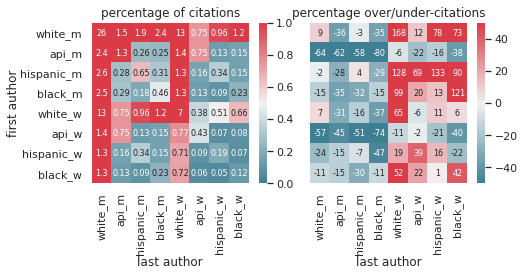

In [5]:
print('Plain text template:')
print(statement)
print('\n')
print('LaTeX template:')
print(statementLatex)

cmap = sns.diverging_palette(220, 10, as_cmap=True)
names = ['white_m','api_m','hispanic_m','black_m','white_w','api_w','hispanic_w','black_w']
plt.close()
sns.set(style='white')
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(7.5,4))
axes = axes.flatten()
plt.sca(axes[0])
heat = sns.heatmap(np.around((citation_matrix/citation_matrix.sum())*100,2),annot=True,ax=axes[0],annot_kws={"size": 8},cmap=cmap,vmax=1,vmin=0)
axes[0].set_ylabel('first author',labelpad=0)  
heat.set_yticklabels(names,rotation=0)
axes[0].set_xlabel('last author',labelpad=1)  
heat.set_xticklabels(names,rotation=90) 
heat.set_title('percentage of citations')  

citation_matrix_sum = citation_matrix / np.sum(citation_matrix) 

expected = np.load('/%s/data/expected_matrix_florida.npy'%(homedir))
expected = expected/np.sum(expected)

percent_overunder = np.ceil( ((citation_matrix_sum - expected) / expected)*100)
plt.sca(axes[1])
heat = sns.heatmap(np.around(percent_overunder,2),annot=True,ax=axes[1],fmt='g',annot_kws={"size": 8},vmax=50,vmin=-50,cmap=cmap)
axes[1].set_ylabel('',labelpad=0)  
heat.set_yticklabels('')
axes[1].set_xlabel('last author',labelpad=1)  
heat.set_xticklabels(names,rotation=90) 
heat.set_title('percentage over/under-citations')
plt.tight_layout()

plt.savefig('/home/jovyan/race_gender_citations.pdf')


paper_df.to_csv('/home/jovyan/predictions.csv')

In [ ]:
# Plot a histogram #
names <- read.csv('/home/jovyan/predictions.csv', header=T)
total_citations <- nrow(na.omit(names))/2
names$GendCat <- gsub("female", "W", names$GendCat, fixed=T)
names$GendCat <- gsub("male", "M", names$GendCat, fixed=T)
names$GendCat <- gsub("unknown", "U", names$GendCat, fixed=T)
gend_cats <- unique(names$GendCat)  # get a vector of all the gender categories in your paper

# Create an empty data frame that will be used to plot the histogram. This will have the gender category (e.g., WW, MM) in the first column and the percentage (e.g., number of WW citations divided by total number of citations * 100) in the second column #
dat_for_plot <- data.frame(gender_category = NA,
                           number = NA,
                           percentage = NA)


### Loop through each gender category from your paper, calculate the citation percentage of each gender category, and save the gender category and its citation percentage in dat_for_plot data frame ###
if (length(names$GendCat) != 1) {
  
  for (i in 1:length(gend_cats)){
    
    # Create an empty temporary data frame that will be binded to the dat_for_plot data frame
    temp_df <- data.frame(gender_category = NA,
                          number = NA,
                          percentage = NA)
    
    # Get the gender category, the number of citations with that category, and calculate the percentage of citations with that category
    gend_cat <- gend_cats[i]
    number_gend_cat <- length(names$GendCat[names$GendCat == gend_cat])
    perc_gend_cat <- (number_gend_cat / total_citations) * 100
    
    # Bind this information to the original data frame
    temp_df$gender_category <- gend_cat
    temp_df$number <- number_gend_cat
    temp_df$percentage <- perc_gend_cat
    dat_for_plot <- rbind(dat_for_plot, temp_df)
    
  }
  
}


# Create a data frame with only the WW, MW, WM, MM categories and their base rates - to plot percent citations relative to benchmarks
dat_for_baserate_plot <- subset(dat_for_plot, gender_category == 'WW' | gender_category == 'MW' | gender_category == 'WM' | gender_category == 'MM')
baserate <- c(6.7, 9.4, 25.5, 58.4)
dat_for_baserate_plot$baserate <- baserate[order(c(which(dat_for_baserate_plot$gender_category == 'WW'), which(dat_for_baserate_plot$gender_category == 'MW'), which(dat_for_baserate_plot$gender_category == 'WM'), which(dat_for_baserate_plot$gender_category == 'MM')))]
dat_for_baserate_plot$citation_rel_to_baserate <- dat_for_baserate_plot$percentage - dat_for_baserate_plot$baserate


# Plot the Histogram of Number of Papers per category against predicted gender category #

library(ggplot2)

dat_for_plot = dat_for_plot[-1:-2,]

dat_for_plot$gender_category <- factor(dat_for_plot$gender_category, levels = dat_for_plot$gender_category)
ggplot(dat_for_plot, aes(x = gender_category, y = number, fill = gender_category)) +
  geom_bar(stat = 'identity', width = 0.75, na.rm = TRUE, show.legend = TRUE) + 
  scale_x_discrete(limits = c('WW', 'MW', 'WM', 'MM', 'UW', 'UM', 'WU', 'MU', 'UU')) +
  geom_text(aes(label = number), vjust = -0.3, color = 'black', size = 2.5) +
  theme(legend.position = 'right') + theme_minimal() +
  xlab('Predicted gender category') + ylab('Number of papers') + ggtitle("") + theme_classic(base_size=15)


# Plot the Histogram of % citations relative to benchmarks against predicted gender category
ggplot(dat_for_baserate_plot, aes(x = gender_category, y = citation_rel_to_baserate, fill = gender_category)) +
  geom_bar(stat = 'identity', width = 0.75, na.rm = TRUE, show.legend = TRUE) +
  scale_x_discrete(limits = c('WW', 'MW', 'WM', 'MM')) +
  geom_text(aes(label = round(citation_rel_to_baserate, digits = 2)), vjust = -0.3, color = 'black', size = 2.5) +
  theme(legend.position = 'right') + theme_minimal() +
  xlab('Predicted gender category') + ylab('% of citations relative to benchmarks') + ggtitle("") + theme_classic(base_size=15)

### (OPTIONAL) Color-code your .tex file using the estimated gender classifications

Running this code-block will optionally output your uploaded `.tex` file with color-coding for gender pair classifications. You can find the [example below's pre-print here.](https://www.biorxiv.org/content/10.1101/664250v1)

![Color-coded .tex file, Eli Cornblath](img/texColors.png)

In [ ]:
cite_gender = pd.read_csv(homedir+'Authors.csv') # output of getReferenceGends.ipynb
cite_gender.index = cite_gender.CitationKey
cite_gender['Color'] = '' # what color to make each gender category
colors = {'MM':'red','MW':'blue','WW':'green','WM':'magenta','UU':'black',
'MU':'black','UM':'black','UW':'black','WU':'black'}
for idx in cite_gender.index: # loop through each citation key and set color
    cite_gender.loc[idx,'Color'] = colors[cite_gender.loc[idx,'GendCat']]
cite_gender.loc[cite_gender.index[cite_gender.SelfCite=='Y'],'Color'] = 'black' # make self citations black

fin = open(homedir+tex_file)
texdoc=fin.readlines()
with open(homedir+tex_file[:-4]+'_gendercolor.tex','w') as fout:
    for i in range(len(texdoc)):
        s = texdoc[i]
        cite_instances = re.findall('\\\\cite\{.*?\}',s)
        cite_keys = re.findall('\\\\cite\{(.*?)\}',s)
        cite_keys = [x.split(',') for x in cite_keys]
        cite_keys_sub = [['\\textcolor{' + cite_gender.loc[x.strip(),'Color'] + '}{\\cite{'+x.strip()+'}}' for x in cite_instance] for cite_instance in cite_keys]
        cite_keys_sub = ['\\textsuperscript{,}'.join(x) for x in cite_keys_sub]
        for idx,cite_instance in enumerate(cite_instances):
            s = s.replace(cite_instances[idx],cite_keys_sub[idx])
        fout.write(s)
        # place color key after abstract
        if '\\section*{Introduction}\n' in s:            
            l = ['\\textcolor{' + colors[k] + '}{'+k+'}' for k in colors.keys()]
            fout.write('\tKey: '+ ', '.join(l)+'.\n')